In [1]:
from langgraph.graph import StateGraph, START
from typing import Annotated, List
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain_core.messages import AnyMessage
from langgraph.prebuilt import ToolNode, tools_condition
from typing import TypedDict


class State(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]

In [2]:
llm = init_chat_model("openai:gpt-4o")

In [3]:
@tool
def get_weather(city: str):
    """ Gets weather in city"""
    return f"The weather in {city} is sunny."

llm_with_tools = llm.bind_tools(tools=[get_weather])

def Agent(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

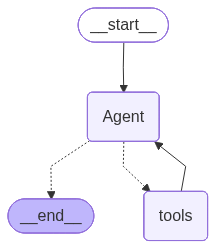

In [4]:
graph_builder = StateGraph(State)

tool_node = ToolNode(
    tools=[get_weather],
)

graph_builder.add_node("Agent", Agent)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "Agent")
graph_builder.add_conditional_edges("Agent", tools_condition)
graph_builder.add_edge("tools", "Agent")

graph = graph_builder.compile()

graph

In [5]:
graph.invoke(
    {
        "messages": [
            {"role": "user", "content": "서울의 날씨를 알려줘"}
        ]
    }
)

{'messages': [HumanMessage(content='서울의 날씨를 알려줘', additional_kwargs={}, response_metadata={}, id='85996038-294d-4768-984d-fde85600502d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3hODPrVDIMWyhJcVhSizsQzL', 'function': {'arguments': '{"city":"서울"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 49, 'total_tokens': 63, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPriMBDR2fYGWmYas7WOkX8cr5f6B', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--571a0129-8d3e-46a2-aee5-018c5ac7b6cc-0', tool_calls=[{'name': 'get_weather', 'args': {'city': '서울'}, 'id': 'call_3hODPrVDIMWyhJcVhSizsQzL', 't